### Load Required Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import norm
import openpyxl


In [3]:
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, default_converter, FloatVector, r, Formula, StrVector
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
utils = rpackages.importr("utils")
utils.chooseCRANmirror(ind=1)          # pick first CRAN mirror
utils.install_packages("metafor")      # download + compile
metafor = importr('metafor')

R callback write-console: trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/metafor_4.8-0.tgz'
  
R callback write-console: Content type 'application/x-gzip'  
R callback write-console:  length 5223184 bytes (5.0 MB)
  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R c


The downloaded binary packages are in
	/var/folders/0_/ls572jc17sd1rk9mkkfbttlh0000gn/T//RtmpSIIhIJ/downloaded_packages


### Define Basics Functions (Cohen's d, Variance)

In [4]:
def cohens_d(r):
    sp=np.sqrt(((r.N_Pre-1)*r.SD_Pre**2+(r.N_Post-1)*r.SD_Post**2)/(r.N_Pre+r.N_Post-2))
    return (r.Mean_Post-r.Mean_Pre)/sp

In [293]:
def var_d(row):
    """
    Variance corrigée pour mesures répétées (pré/post sur mêmes sujets)
    Basée sur Morris & DeShon (2002) - formule utilisée par metafor
    """
    n = row['N_Pre']  # même N pour pré et post dans mesures répétées
    d = cohens_d(row)

    # Corrélation pré/post estimée (ajustez selon votre domaine)
    r_pre_post = 0.5  # corrélation modérée

    # Formule corrigée pour mesures répétées
    variance = (1/n) * (2 * (1 - r_pre_post)) + (d**2 / (2 * n))

    return variance

### Meta-Analysis of All Studies (with Metafor REML)

1. Define the function forest_all
2. Load and read dataset
3. Attribute a color to each study type (palette)
4. Visualize forest_all

In [184]:
### DEFINE FOREST_ALL
def old_forest_all(df):
    df_all = df.copy()

    df_all['d'] = df_all.apply(cohens_d, axis=1)
    df_all['var'] = df_all.apply(var_d,  axis=1)

    with localconverter(default_converter + pandas2ri.converter):
        r_yi = ro.FloatVector(df_all["d"].values)
        r_vi = ro.FloatVector(df_all["var"].values)

    r_res = metafor.rma(r_yi, r_vi, method="REML")

    d = float(r_res.rx2("b")[0])
    se = float(r_res.rx2("se")[0])
    ci_lo, ci_hi = d + norm.ppf([.025, .975]) * se
    tau2 = float(r_res.rx2("tau2")[0])
    I2 = float(r_res.rx2("I2")[0])
    pred = metafor.predict_rma(r_res)
    pi_lo, pi_hi = float(pred.rx2("pi.lb")[0]), float(pred.rx2("pi.ub")[0])

    df_all = df_all.sort_values("d")

    # Y-column labels
    #df_all["label"] = df_all.apply(
    #    lambda r: (
    #            r["Activity"] +  # ligne 1
    #            "\n" +
    #            f"{r['Population']} (" +  # ligne 2 (début)
    #            r"$N_{\mathrm{pre}}$ =" + str(int(r["N_Pre"])) + ", " +
    #            r"$N_{\mathrm{post}}$ =" + str(int(r["N_Post"])) + "), " +
    #            r["HNC"] +
    #            "\n" +  # ligne 3
    #            r["Citation"]
    #    ),
    #    axis=1)

    df_all["label"] = df_all.apply(
        lambda row: f"{row['Citation']}"
                    f"\n{row['Technology']} - {row['Family']}"
                    #f"\n{row['Experience']} - {row['Nature']}"
                    f"\n{row['HNC']}, {row['Duration']}, {row['GroupID']}",
                    #r"$N_{\mathrm{pre}}$ ="+ f"{str(int(row["N_Pre"]))}"
                    #r"$N_{\mathrm{post}}$ =" + f"{str(int(row["N_Post"]))}",
    axis=1
    )

    tech_colors = {
        "Virtual Reality": "darkblue",
        "Responsive Instrument": "gold",
        "Citizen Science App": "forestgreen",
        "Photography": "limegreen",
        "Well-Being App": "pink"
    }

    scale_markers = {
        "INS": "^",    # triangle
        "CNS": "*",    # star
        "NR-6": "s",   # square
        "NRS": "D"     # diamond
    }
    # FIGURE
    y = np.arange(len(df_all))
    ci_each = 1.96 * np.sqrt(df_all["var"])
    fig_h = 0.55 * (len(df_all) + 4)
    fig, ax = plt.subplots(figsize=(7, fig_h))

    for i in range(len(df_all)):
        tech_color = tech_colors.get(df_all["Technology"].iloc[i], "black")
        hnc_marker = scale_markers.get(df_all["HNC"].iloc[i], "s")
        ax.errorbar(df_all["d"].iloc[i], y[i],
                    xerr=ci_each.iloc[i],
                    fmt=hnc_marker,
                    color=tech_color,
                    ecolor='gray',
                    capsize=3)

    # X-axis
    ax.axvline(0, color="grey", ls="--")
    ax.set_xlim(-2, 2)
    ax.set_xticks(np.arange(-2, 2.1, 0.5))
    ax.set_xlabel("Cohen's d (95% CI)")

    # Y-axis
    ax.set_yticks(y)
    ax.set_yticklabels(df_all["label"], fontsize=8)
    ax.invert_yaxis()
    dy = len(df_all) - 0.2
    ax.set_ylim(-0.5, dy + 1.5)

    # Title
    ax.set_title("Forest plot of 23 effect sizes (17 experimental groups) from 11 studies\nassessing the Impact of Technology-Mediated Nature Experiences\non Nature Connectedness",fontweight="bold",fontsize=10)

    # Mean Size Effect
    ax.errorbar(d, dy,
            xerr=[[d - ci_lo], [ci_hi - d]],
            fmt='o', color='royalblue', ecolor='dodgerblue',
            capsize=4, markersize=6, label="Pooled effect")

    ax.text(2.2, dy+0.4,"Cohen's $d$  [95% CI]", va='center', fontsize=8, color='black', fontweight="bold")

    ax.text(2.2, dy, f'{d:.2f} [{ci_lo:.2f}, {ci_hi:.2f}]', va='center', fontsize=8, color='dodgerblue', fontweight="bold")

    plt.axvline(x=0.29, color='dodgerblue', linestyle='--', linewidth=1, label='Pooled effect (d = 0.29)')

    # Mean Size Effect (for each study)
    for idx, (dval, lo, hi) in enumerate(zip(df_all["d"], df_all["d"] - ci_each, df_all["d"] + ci_each)):
        ax.text(2.2, idx, f"{dval:5.2f} [{lo:5.2f}, {hi:5.2f}]", va="center", fontsize=8)

    # Heterogeneity card
    card = f"k={len(df_all)}\nτ²={tau2:.3f}\nI²={I2:.1f}%\n95% PI: [{pi_lo:.2f}, {pi_hi:.2f}]"
    ax.text(-2.2, dy + 1.2, card, ha="left", va="top",
            bbox=dict(boxstyle="round", fc="white", ec="grey"), fontsize=9)

    for sp in ("left", "right", "top"):
        ax.spines[sp].set_visible(False)

    # Légende des technologies (couleurs)
    legend_tech = [Line2D([0], [0], marker='s', color='w', label=tech,
                      markerfacecolor=color, markersize=8)
               for tech, color in tech_colors.items()]

    # Légende des échelles HNC (formes)
    legend_scale = [Line2D([0], [0], marker=marker, color='grey', linestyle='None',
                           label=scale, markerfacecolor='grey', markersize=8)
                    for scale, marker in scale_markers.items()]

    # Légende technologie
    fig.legend(handles=legend_tech, title="Technology Type",
               loc='lower center', bbox_to_anchor=(0.5, -0.025),
               ncol=5, fontsize=8, title_fontsize=9,
               frameon=True, framealpha=1, facecolor='whitesmoke', edgecolor='lightgrey')

    # Légende HNC scale
    fig.legend(handles=legend_scale, title="Psychometric Scale",
               loc='lower center', bbox_to_anchor=(0.5, -0.055),
               ncol=4, fontsize=8, title_fontsize=9,
               frameon=True, framealpha=1, facecolor='whitesmoke', edgecolor='lightgrey')

    plt.grid(visible=True)
    plt.tight_layout()
    fig.savefig("All_studies.png", dpi=150, bbox_inches="tight")
    plt.show()

In [322]:
def forest_all(df):
    df_all = df.copy()

    # Calcul des tailles d’effet et variances
    df_all['d'] = df_all.apply(cohens_d, axis=1)
    df_all['var'] = df_all.apply(var_d,  axis=1)

    with localconverter(default_converter + pandas2ri.converter):
        r_yi = ro.FloatVector(df_all["d"].values)
        r_vi = ro.FloatVector(df_all["var"].values)

    r_res = metafor.rma(r_yi, r_vi, method="REML")

    d = float(r_res.rx2("b")[0])
    se = float(r_res.rx2("se")[0])
    ci_lo, ci_hi = d + norm.ppf([.025, .975]) * se
    tau2 = float(r_res.rx2("tau2")[0])
    I2 = float(r_res.rx2("I2")[0])
    pred = metafor.predict_rma(r_res)
    pi_lo, pi_hi = float(pred.rx2("pi.lb")[0]), float(pred.rx2("pi.ub")[0])

    df_all = df_all.sort_values("d")

    # Étiquettes pour l’axe Y
    df_all["label"] = df_all.apply(
        lambda row: f"{row['Citation']}\n"
                    f"{row['Technology']} - {row['Family']}\n{row['HNC']}, {row['Duration']}, {row['GroupID']}",
        axis=1
    )

    # Couleurs des technologies
    tech_colors = {
        "Citizen Science App": '#BAC55D',
        "Photography": "#2DD6CA",
        "Well-Being App": "#E1B566",
        "Virtual Reality": "#FE9AAA",
        'Video Games': "#FD94E1",
        "Well-Being App": "#E1B566",
        "Responsive Instrument": "#C9A8FF",
    }

    # Formes des échelles psychométriques
    scale_markers = {
        "INS": "^",
        "CNS": "*",
        "NR-6": "s",
        "NRS": "D"
    }

    # Ajout de la ligne "Pooled effect"
    pooled_row = pd.DataFrame({
        "d": [d], "var": [se**2],
        "Technology": [" "], "HNC": [" "],
        "label": ["Pooled effect"]
    })

    df_all = pd.concat([df_all, pooled_row], ignore_index=True)

    y = np.arange(len(df_all))
    ci_each = 1.96 * np.sqrt(df_all["var"])
    fig_h = 0.55 * (len(df_all) + 2)
    fig, ax = plt.subplots(figsize=(8, fig_h))

    # Tracer les études individuelles
    for i in range(len(df_all) - 1):
        tech_color = tech_colors.get(df_all["Technology"].iloc[i], "black")
        hnc_marker = scale_markers.get(df_all["HNC"].iloc[i], "s")
        ax.errorbar(df_all["d"].iloc[i], y[i],
                    xerr=ci_each.iloc[i],
                    fmt=hnc_marker, color=tech_color, ecolor='gray', capsize=3)

    # Tracer l’effet global (pooled)
    ax.errorbar(df_all["d"].iloc[-1], y[-1],
                xerr=ci_each.iloc[-1],
                fmt='o', color='dodgerblue', ecolor='dodgerblue',
                capsize=4, markersize=8, label="Pooled effect")
    ax.text(2.2, y[-1]+0.4, "Cohen’s $d$  [95% CI]",
            va='center', fontsize=8, color='black', fontweight="bold")
    #ax.text(2.2, y[-1], f"{d:.2f} [{ci_lo:.2f}, {ci_hi:.2f}]",
    #        va='center', fontsize=8, color='dodgerblue', fontweight="bold")

    # Axes et titres
    ax.axvline(0, color="grey", ls="--")
    #ax.axvline(x=0.29, color='dodgerblue', linestyle='--', linewidth=1)
    ax.set_xlim(-2, 2)
    ax.set_xticks(np.arange(-2, 2.1, 0.5))
    ax.tick_params(axis='x', labelsize=8)
    ax.set_xlabel("Cohen's d (95% CI)",fontsize=8)
    ax.set_yticks(y)
    ax.set_yticklabels(df_all["label"], fontsize=8)
    ax.invert_yaxis()
    ax.set_ylim(-0.5, len(df_all)-0.2)

    # Mise en valeur de la ligne "Pooled effect"
    labels = ax.get_yticklabels()
    labels[-1].set_color('dodgerblue')
    labels[-1].set_fontweight('bold')

    ax.set_title("Technology-Mediated Nature Experiences and Nature Connectedness\n"
             "Forest plot of 23 effect sizes from 11 studies (Cohen’s d with 95% CI)",
             fontweight="bold", fontsize=10)

    # Valeurs numériques à droite
    for idx, (dval, lo, hi) in enumerate(zip(df_all["d"], df_all["d"] - ci_each, df_all["d"] + ci_each)):
        ax.text(2.2, idx, f"{dval:5.2f} [{lo:5.2f}, {hi:5.2f}]", va="center", fontsize=8)

    # Carte d'hétérogénéité compacte
    #card = f"k = {len(df_all)-1}, τ² = {tau2:.3f}, I² = {I2:.1f}%\n95%PI = [{pi_lo:.2f}, {pi_hi:.2f}]"

    card = ("Heterogeneity\n"
             f"k = {len(df_all)-1}, τ² = {tau2:.3f}\nI² = {I2:.1f}%\n"
             f"95%PI = [{pi_lo:.2f}, {pi_hi:.2f}]")

    # Position : en haut à gauche, hors du nuage de points
    ax.text(2.2, -0.65, card,
        ha="left", va="top",
        fontsize=8.5,
        bbox=dict(boxstyle="round", fc="whitesmoke", ec="whitesmoke"))

    for sp in ("left", "right", "top"):
        ax.spines[sp].set_visible(False)

    # Légendes
    legend_tech = [Line2D([0], [0], marker='s', color='w', label=tech,
                          markerfacecolor=color, markersize=8)
                   for tech, color in tech_colors.items()]
    legend_scale = [Line2D([0], [0], marker=marker, color='grey', linestyle='None',
                           label=scale, markerfacecolor='grey', markersize=8)
                    for scale, marker in scale_markers.items()]

    fig.legend(handles=legend_tech, title="Technology Type",
               loc='lower center', bbox_to_anchor=(0.5, -0.025),
               ncol=6, fontsize=8, title_fontsize=9,
               frameon=True, framealpha=1, facecolor='whitesmoke', edgecolor='lightgrey')

    fig.legend(handles=legend_scale, title="Psychometric Scale",
               loc='lower center', bbox_to_anchor=(0.5, -0.055),
               ncol=4, fontsize=8, title_fontsize=9,
               frameon=True, framealpha=1, facecolor='whitesmoke', edgecolor='lightgrey')

    fig.text(0.01, 0.01,
         "CI = Confidence Interval • PI = 95% Prediction Interval",
         fontsize=7, ha="left", va="bottom", color="gray")

    fig.subplots_adjust(bottom=0.15)

    plt.grid(visible=True)
    plt.tight_layout()
    fig.savefig("All_studies.png", dpi=150, bbox_inches="tight")
    plt.show()

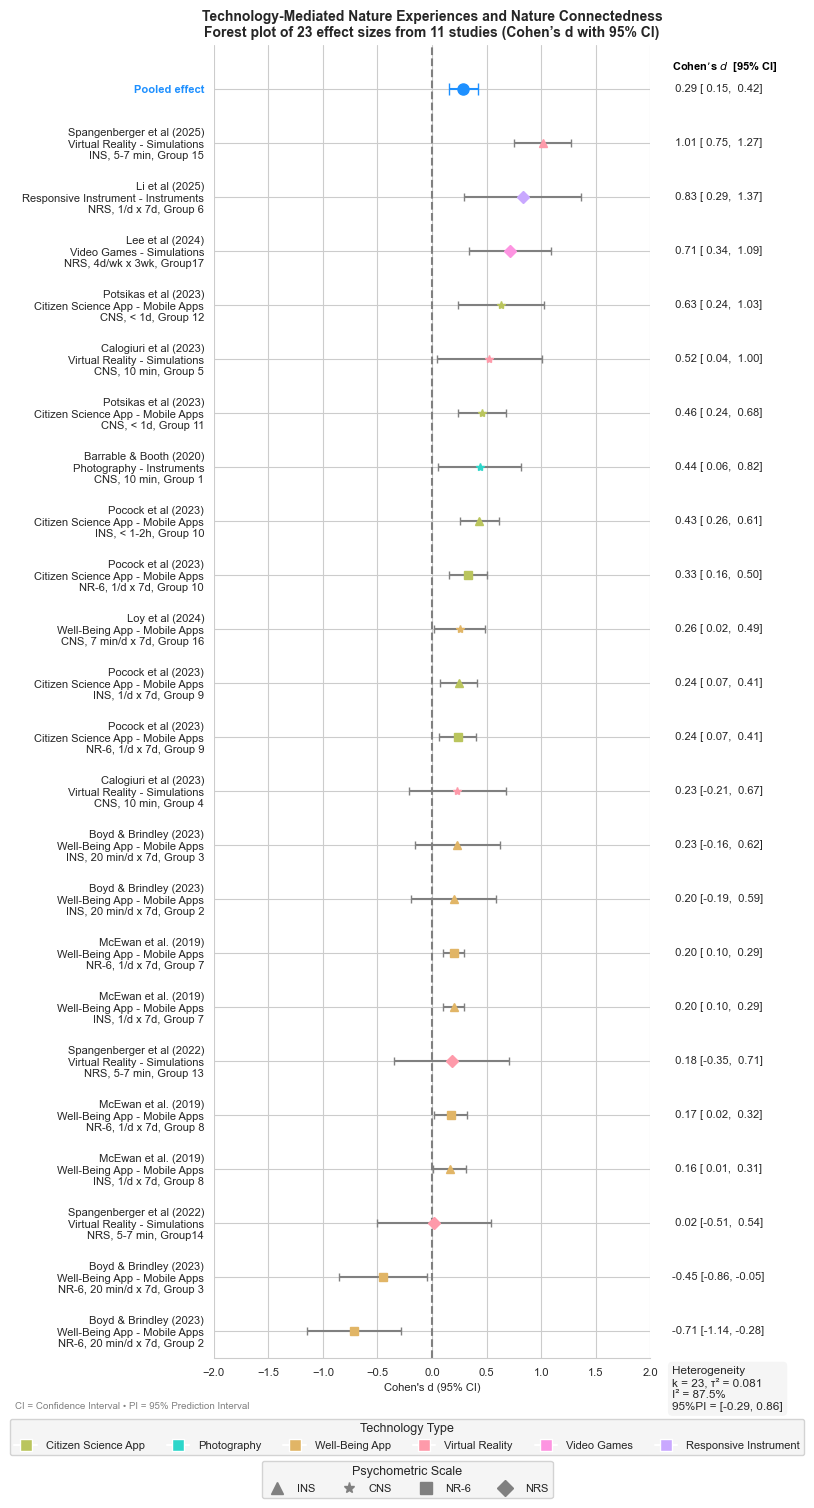

In [323]:
### LOAD AND READ DATASET
tech_df = pd.read_excel('~/Desktop/Review/Data/meta.xlsx', sheet_name='techno')
num_cols=['N_Pre','Mean_Pre','SD_Pre','N_Post','Mean_Post','SD_Post']
tech_df[num_cols]=tech_df[num_cols].apply(pd.to_numeric,errors='coerce')
tech_df=tech_df.dropna(subset=num_cols)

### VISUALIZE FOREST_ALL
forest_all(tech_df)

### Meta-Analysis by HNC Scale

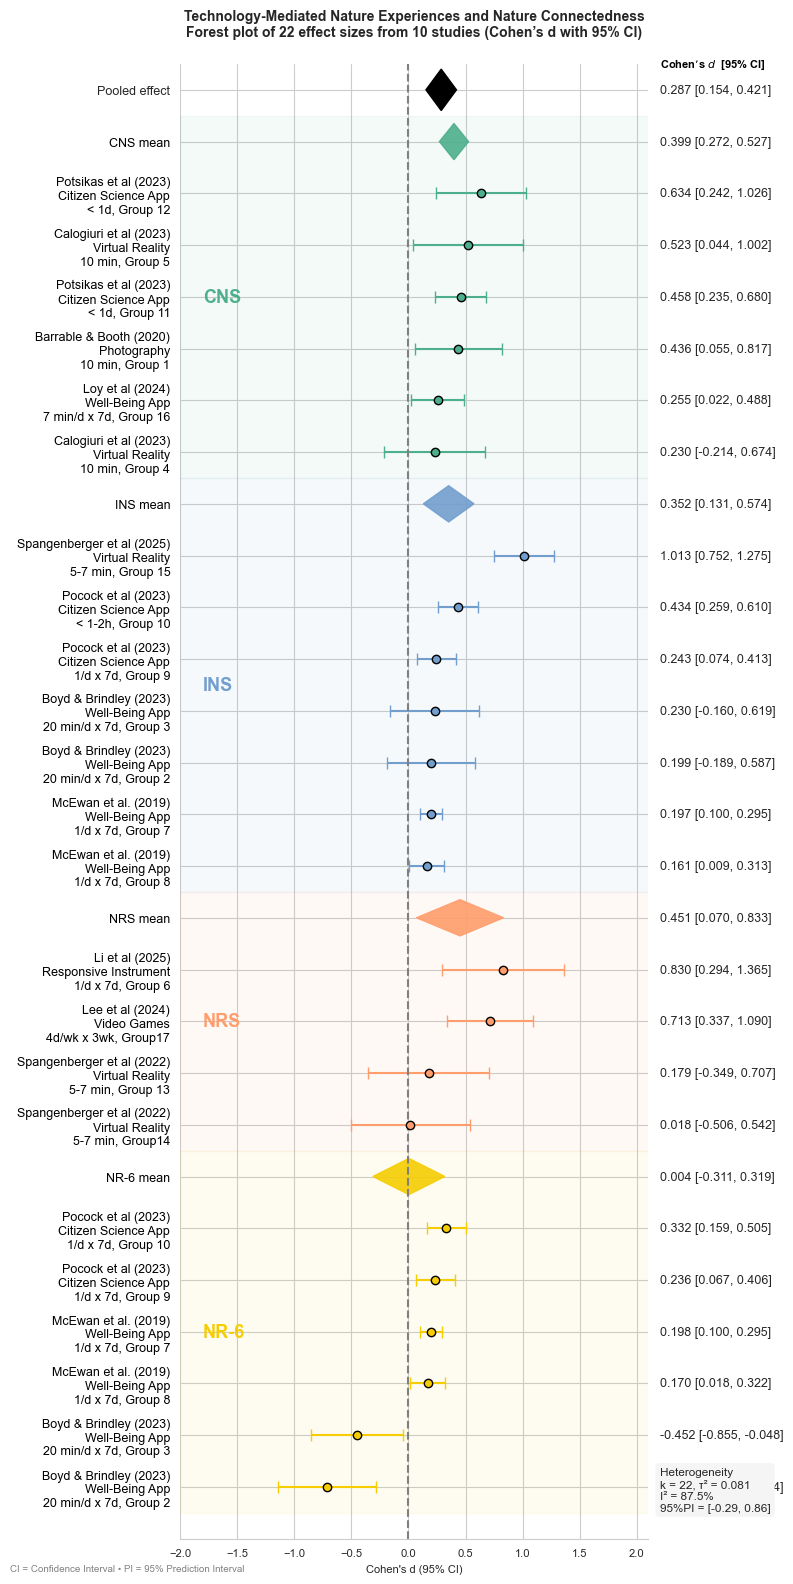

In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.patches import Polygon
from scipy.stats import norm
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, default_converter
import rpy2.robjects.packages as rpackages

# -----------------------------------------------------------
#  1. Préparation des données et fonctions utilitaires
# -----------------------------------------------------------

def cohens_d(row):
    # calcul de d pour pré/post : (M_post − M_pre) / SD_pooled
    sd_pooled = np.sqrt(((row['N_Pre']-1)*row['SD_Pre']**2 +
                         (row['N_Post']-1)*row['SD_Post']**2) /
                        (row['N_Pre'] + row['N_Post'] - 2))
    return (row['Mean_Post'] - row['Mean_Pre']) / sd_pooled

#def var_d(row):
    # variance approximative de d (pré/post indépendants)
#    return (row['N_Pre'] + row['N_Post'])/(row['N_Pre'] * row['N_Post']) + \
#           cohens_d(row)**2 / (2*(row['N_Pre'] + row['N_Post']))

def var_d(row):
    """
    Variance corrigée pour mesures répétées (pré/post sur mêmes sujets)
    Basée sur Morris & DeShon (2002) - formule utilisée par metafor
    """
    n = row['N_Pre']  # même N pour pré et post dans mesures répétées
    d = cohens_d(row)

    # Corrélation pré/post estimée (ajustez selon votre domaine)
    r_pre_post = 0.5  # corrélation modérée

    # Formule corrigée pour mesures répétées
    variance = (1/n) * (2 * (1 - r_pre_post)) + (d**2 / (2 * n))

    return variance

### LOAD AND READ DATA
tech_df = pd.read_excel('~/Desktop/Review/Data/meta.xlsx', sheet_name='techno')
df = tech_df.copy()

# Harmoniser / nettoyer
#df['HNC'] = df['HNC'].replace({'NR-6':'NR', 'NRS':'NR'})
df['d']   = df.apply(cohens_d, axis=1)
df['var'] = df.apply(var_d, axis=1)


df["label_full"] = df.apply(
        lambda row: f"{row['Citation']}\n"
                    f"{row['Technology']}\n{row['Duration']}, {row['GroupID']}",
        axis=1)

# -----------------------------------------------------------
#  2. Palettes de couleurs
# -----------------------------------------------------------

#order_hnc   = ['CNS','NR', 'INS']
#pal_hnc     = {'CNS':'#4daf8c', 'NR':'#ff9d6c', 'INS':'#729ece'}      # bande pastel + diamants
order_hnc   = ['CNS','INS','NRS','NR-6']
pal_hnc     = {'CNS':'#4daf8c','INS':'#729ece', 'NRS':'#ff9d6c','NR-6':'#F6CD03'}      # bande pastel + diamants
groups      = df['Approach'].unique()
pal_group   = dict(zip(groups, sns.color_palette('husl', len(groups)))) # couleur des labels

# -----------------------------------------------------------
#  3. Construction du DataFrame de tracé (diamants + études)
# -----------------------------------------------------------

metafor = rpackages.importr('metafor')
rows = []

for h in order_hnc:
    sub = df[df['HNC'] == h]
    if sub.empty:          # si pas d’études pour ce HNC, on saute
        continue

    # méta-analyse REML pour le diamant du sous-groupe
    with localconverter(default_converter + pandas2ri.converter):
        r_yi=ro.FloatVector(sub['d'])
        r_vi=ro.FloatVector(sub['var'])

    res = metafor.rma(r_yi,r_vi,method = 'REML')
    d_s, se_s = float(res.rx2('b')[0]), float(res.rx2('se')[0])
    lo_s, hi_s = d_s + norm.ppf([.025, .975]) * se_s

    rows.append({'HNC':h, 'Group':h,  # Group fictif pour qu’il existe, non utilisé
                 'd':d_s, 'lo':lo_s, 'hi':hi_s,
                 'is_diamond':True,
                 'label':h + ' mean'})

    # Études triées d décroissant
    sub = sub.sort_values('d', ascending=False)
    for _, r in sub.iterrows():
        ci = 1.96 * np.sqrt(r['var'])
        rows.append({'HNC':r['HNC'],
                     'Group':r['Group'],
                     'd':r['d'],
                     'lo':r['d'] - ci,
                     'hi':r['d'] + ci,
                     'is_diamond':False,
                     'label':r['label_full']})

plot_df = pd.DataFrame(rows).reset_index(drop=True)

# -----------------------------------------------------------
#  4. Effet global (diamant noir)
# -----------------------------------------------------------

with localconverter(default_converter + pandas2ri.converter):
    r_yi = ro.FloatVector(df['d'])
    r_vi = ro.FloatVector(df['var'])

res_all = metafor.rma(r_yi,r_vi,method = 'REML')
d_over, se_over = float(res_all.rx2('b')[0]), float(res_all.rx2('se')[0])
lo_over, hi_over = d_over + norm.ppf([.025, .975]) * se_over

tau2 = float(res_all.rx2("tau2")[0])
I2 = float(res_all.rx2("I2")[0])
pred = metafor.predict_rma(res_all)
pi_lo, pi_hi = float(pred.rx2("pi.lb")[0]), float(pred.rx2("pi.ub")[0])


# -----------------------------------------------------------
#  5. Tracé du forest-plot
# -----------------------------------------------------------

n_rows = len(plot_df)
fig_height = 0.55 * (n_rows + 2)
fig, ax = plt.subplots(figsize=(8, fig_height))

# (a) Diamant global en haut
overall_y = -1
ax.add_patch(Polygon([[lo_over, overall_y],
                      [d_over,  overall_y + 0.4],
                      [hi_over, overall_y],
                      [d_over,  overall_y - 0.4]],
                     closed=True, color='black'))
ax.text(2.2, overall_y,
        f'{d_over:.3f} [{lo_over:.3f}, {hi_over:.3f}]',
        va='center', fontsize=9)

# (b) Blocs HNC (bande pastel + titre)
start = 0
for h in order_hnc:
    blk = plot_df[plot_df['HNC'] == h]
    if blk.empty:
        continue
    end = start + len(blk) - 1
    ax.axhspan(start - 0.5, end + 0.5,
               color = pal_hnc[h], alpha = 0.06)
    ax.text(-1.8, (start + end)/2, h,
            va='center', ha='left',
            fontsize=13, fontweight='bold',
            color = pal_hnc[h])
    start = end + 1

# (c) Études et diamants de sous-groupe
for i, row in plot_df.iterrows():
    if row['is_diamond']:
        ax.add_patch(Polygon([[row['lo'], i],
                              [row['d'],  i + 0.35],
                              [row['hi'], i],
                              [row['d'],  i - 0.35]],
                             closed=True,
                             color = pal_hnc[row['HNC']],
                             alpha = 0.9))
    else:
        ax.errorbar(row['d'], i,
                    xerr=[[row['d'] - row['lo']],
                          [row['hi'] - row['d']]],
                    fmt='o',
                    mfc = pal_hnc[row['HNC']],
                    mec = 'black',
                    ecolor = pal_hnc[row['HNC']],
                    color = 'black',
                    capsize = 4,
                    markersize = 6)

    # Colonne numérique d & IC 95 %
    ax.text(2.2, i,
            f'{row["d"]:.3f} [{row["lo"]:.3f}, {row["hi"]:.3f}]',
            va='center', fontsize=9)

# (d) Axe Y : libellés colorés par Activity Group
ax.set_yticks(np.append(overall_y, np.arange(n_rows)))
ax.set_yticklabels(['Pooled effect'] + list(plot_df['label']), fontsize=9)
for tick_value, tick_label in zip(ax.get_yticks()[1:], ax.get_yticklabels()[1:]):
    grp = plot_df.loc[int(tick_value), 'Group']
    tick_label.set_color(pal_group.get(grp, 'black'))

# (e) Mise en forme finale
ax.text(2.2, -1.5, "Cohen’s $d$  [95% CI]",
        va='center', fontsize=8, color='black', fontweight="bold")

ax.invert_yaxis()
ax.set_ylim(start, -1.5)
ax.axvline(0, color='grey', ls='--')
ax.set_xlim(-2, 2.1)
ax.tick_params(axis='x', labelsize=8)
ax.set_xticks(np.arange(-2, 2.1, 0.5))
ax.set_xlabel("Cohen's d (95% CI)",fontsize=8)

card = ("Heterogeneity\n"
         f"k = {len(df)-1}, τ² = {tau2:.3f}\nI² = {I2:.1f}%\n"
         f"95%PI = [{pi_lo:.2f}, {pi_hi:.2f}]")

ax.text(2.2, 26.5, card,
    ha="left", va="bottom",
    fontsize=8.5,
    bbox=dict(boxstyle="round", fc="whitesmoke", ec="whitesmoke"))


ax.set_title("Technology-Mediated Nature Experiences and Nature Connectedness\n"
         "Forest plot of 22 effect sizes from 10 studies (Cohen’s d with 95% CI)",
         fontweight="bold", fontsize=10, pad=20)

for side in ('left', 'right', 'top'):
    ax.spines[side].set_visible(False)

fig.text(0.01, 0.01,
     "CI = Confidence Interval • PI = 95% Prediction Interval",
     fontsize=7, ha="left", va="bottom", color="gray")

plt.tight_layout()
plt.grid(visible=True)
plt.savefig('forest.png', dpi=150, bbox_inches='tight')
plt.show()

### Meta-Analysis by Activity (with Metafor REML)

1. Define the function assign_group
2. Define the function forest_group
3. Load and read dataset
4. Assign a group to each study
5. Visualize forest_group

In [10]:
def assign_group(r):
    return r['Group'].strip()

In [281]:
def forest_group(df,subgroup,group_col,save_png=False):

    # df        : dataset
    # subgroup  : tech_df["Group"].unique() OR tech_df["Experience"].unique() OR tech_df["HNC"].unique()
    # group_col : "Group" OR "Experience" OR "HNC"
    # save_png  : True OR False

    sub = df[df[group_col] == subgroup].copy()

    sub['d']=sub.apply(cohens_d,axis=1)
    sub['var']=sub.apply(var_d,axis=1)

    sub=sub.sort_values('d')

    # REML via metafor
    yi=sub['d'].values
    vi=sub['var'].values

    with localconverter(default_converter + pandas2ri.converter):
        r_yi=ro.FloatVector(yi); r_vi=ro.FloatVector(vi)

    r_res=metafor.rma(r_yi,r_vi,method='REML')
    d=float(r_res.rx2('b')[0])
    se=float(r_res.rx2('se')[0])
    ci_lo,ci_hi=d+norm.ppf([0.025,0.975])*se

    pred=metafor.predict_rma(r_res)

    pi_lo=float(pred.rx2('pi.lb')[0])
    pi_hi=float(pred.rx2('pi.ub')[0])

    tau2=float(r_res.rx2('tau2')[0])
    I2=float(r_res.rx2('I2')[0])

    # FIGURE
    n=len(sub)
    fig_h=0.55*(n+3)
    fig,ax=plt.subplots(figsize=(8.5,fig_h))

    y=np.arange(n)

    # Confidence Interval
    ci_each=1.96*np.sqrt(sub['var'])
    ax.errorbar(sub['d'],y,xerr=ci_each,fmt='s',color='black',capsize=3)

    # X-axis
    ax.axvline(0,color='grey',ls='--')
    ax.set_xlim(-3,3)
    ax.set_xticks(np.arange(-3,3.1,1))
    ax.set_xlabel("Cohen's d (95% CI)")

    # Y-column : Study labels
    sub["label"] = sub.apply(
    lambda r: (
        r["Activity"] +                               # ligne 1
        "\n" +
        f"{r['Population']} (" +                      # ligne 2 (début)
    #    r"$N_{\mathrm{pre}}$ =" + str(int(r["N_Pre"])) + ", " +
    #    r"$N_{\mathrm{post}}$ =" + str(int(r["N_Post"])) + "), " +
        r["HNC"] +
        "\n" +                                        # ligne 3
        r["Citation"]
    ),
    axis=1)

    # Y-axis
    ax.set_yticks(y)
    ax.set_yticklabels(sub["label"],fontsize=8)
    ax.invert_yaxis()
    dy = n + 0.5
    ax.set_ylim(-0.5,dy+1.5)

    # Title
    ax.set_title(f"{subgroup} (n={n} experimental groups)",fontsize=10, fontweight='bold')

    # Mean Effect Size + Label
    ax.add_patch(Polygon([[ci_lo,dy],[d,dy+0.3],[ci_hi,dy],[d,dy-0.3]],closed=True,color="royalblue",alpha=0.8))
    ax.text(3.2, dy, f'd={d:.2f}\n95%CI=[{ci_lo:.2f}, {ci_hi:.2f}]', va='center', fontsize=8, color='royalblue')

    # Mean Effect + Confidence Interval for Each Study
    for idx,(dval,lo,hi) in enumerate(zip(sub['d'],sub['d']-ci_each,sub['d']+ci_each)):
        ax.text(3.2,idx,'{:.2f} [{:.2f}, {:.2f}]'.format(dval,lo,hi),va='center',fontsize=8)

    for s in ('left','right','top'):
        ax.spines[s].set_visible(False)

    plt.tight_layout()

    if save_png:
        fn=subgroup.replace(' ','_').replace(':','')+'_REML.png'
        fig.savefig(fn,dpi=150,bbox_inches='tight')
        print('saved',fn)

    plt.show()

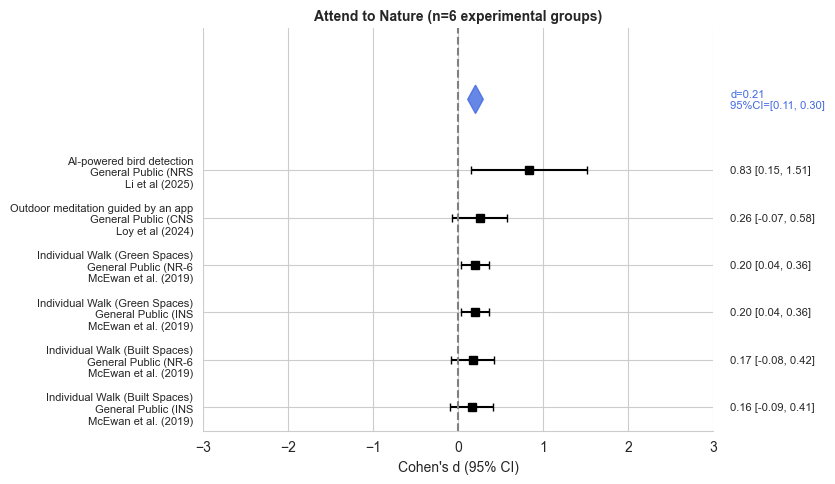

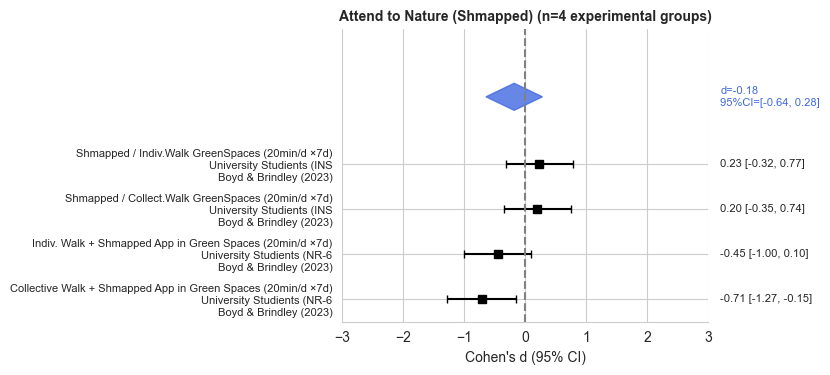

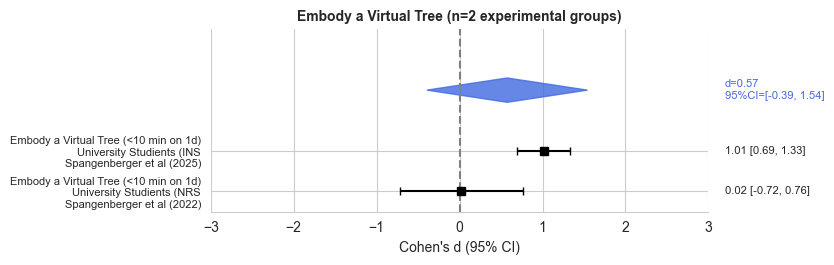

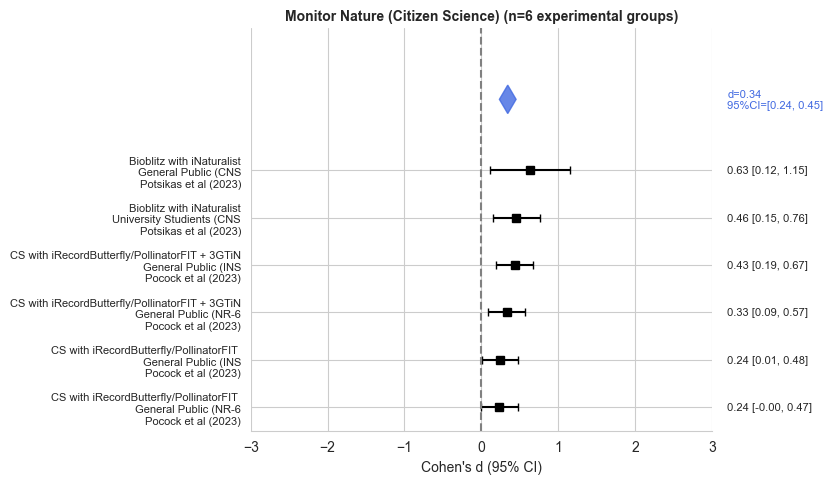

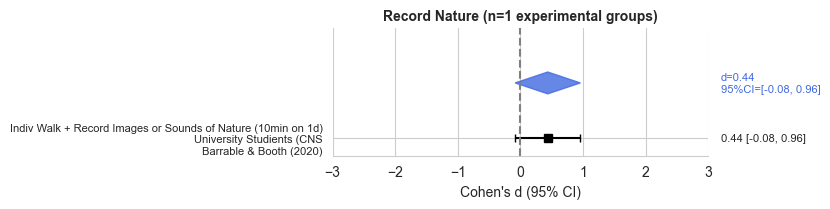

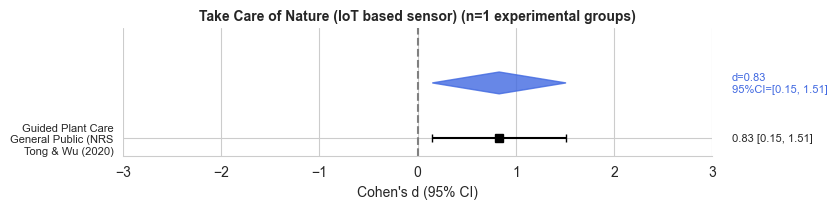

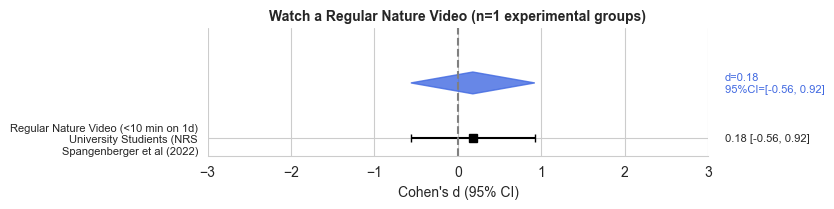

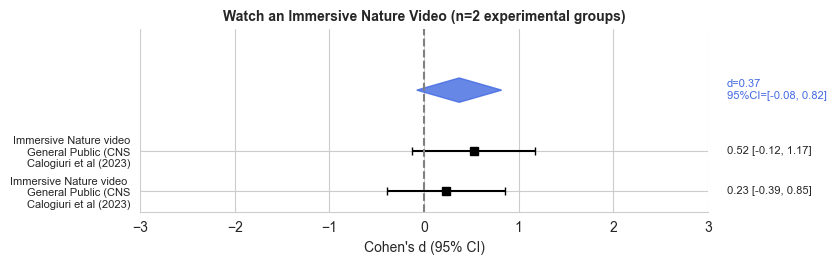

In [282]:
### LOAD AND READ DATA
tech_df = pd.read_excel('~/Desktop/Review/Data/meta.xlsx', sheet_name='techno')
num_cols=['N_Pre','Mean_Pre','SD_Pre','N_Post','Mean_Post','SD_Post']
tech_df[num_cols]=tech_df[num_cols].apply(pd.to_numeric,errors='coerce')
tech_df=tech_df.dropna(subset=num_cols)

### ASSIGN GROUPS
tech_df['Group'] = tech_df.apply(assign_group, axis=1)

### VISUALIZE FOREST_GROUP
for grp in sorted(tech_df['Group'].unique()):
    forest_group(tech_df,subgroup=grp,group_col='Group',save_png=False)
